# Basics of mobile robotics - Thymio Project
## Students : Colomban Fussinger, André Gomes, Anthony Guinchard, Sylvain Pietropaolo

## Introduction

The goal of this project is to combine vision, path planning, local navigation and filtering to maneuver a Thymio robot on a map around obstacles. First a picture of the map is taken where the robot will navigate. From this picture, the map pattern is saved, the obstacles are highlighted and the start position and orientation are shown on a plot in order to help to select the goal. Once chosen the algorithm computes the optimal path and send the instructions to the Thymio robot. The robot sends back to the computer the odometry and the colors seen under his bodyshell but also indicates the presence of obstacle in front of him. These informations are used by the computer to compute the position of the robot and then to give instructions to the motors to follow the optimal path and to avoid the obstacles.

## Specifications and limitations

### Vision

<ul>
    <li>One single picture is taken at the beginning of the program (the map should appear slightly tilted on one or the other side). The map is made with a pattern of black and white square cells with a size of 3 cm for each square. The border of the map is composed of black cells only. The fixed obstacles should be put above the map before taking the picture. The physical obstacles (for local navigation) should be placed on the ground once the picture is taken.</li>
    <li>The robot, the fixed obstacles and the mobile obstacles have to be placed inside the delimitation of the map (i.e. strictly inside the outer black rectangle). Moreover, due to perspective problems, the Thymio shouldn’t be touching the border. 
In the frame of the picture to be taken, a white margin is needed around the black delimitation rectangle</li>
    <li>The obstacles should be green (RGB = [0 255 0]) and the robot should have a special pattern (red and blue) on the top in order to detect the position and orientation. The obstacles shouldn’t be near the border of the map otherwise the algorithm would make the robot go out of the map if the empty space isn’t as large as the robot.</li>
</ul>


### Global Navigation

<ul>
    <li> A* algorithm is quite computationally heavy, therefore its computational time can become large (not linear) if the goal is far in term of distance or if the obstacles make the path complicated. </li>
    <li> The A* algorithm won’t find a way if the robot is surrounded with obstacles and the goal cannot be reached. In this case it will throw an error. </li>
    <li> There is 8 possible directions of movement which are implemented in the A* algorithm: north, north-east, east, south-east, south, south-west, west, north-west. Therefore, if the optimal path isn’t in one of these directions, the optimal path contains a combination of these directions which leads to an accumulation of error when the robot follows this route (due to many changes of direction). </li>
    <li> The goal cannot be changed while the robot is moving. One needs to wait for the robot to reach the previous goal before setting another one manually in the code. </li>
</ul>


### Local Navigation

<ul>
    <li> The physical obstacle should not straddle the contour of the map and should be at least 5 cells away of a vision obstacle. </li>
    <li> The physical obstacles color should be white in order to have an optimal detection. </li>
</ul>

### Filtering

<ul>
    <li> The robot can’t move through an arc of circle but should turn around the center of its wheels axis or move straight forward.</li>
    <li> The robot should move on a map with a random black and white cells pattern (as a QR code). </li>
    <li> The robot is implemented for a motor speed of 50 (motor.'side'.target) (going straight or turning). </li>
    <li> Kidnapping is not allowed. </li>
</ul>


# Imports

In [7]:
import cv2
import imageio
import math as m
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.ndimage
import serial
import sys
import time

from matplotlib import colors
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from numpy import ndarray
from PIL import Image
from random import sample
from scipy import signal

%matplotlib inline

# Connexion to Thymio

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from Thymio import Thymio
th = Thymio.serial(port="COM5", refreshing_rate=0.1)

# Vision

#### Input
<ul>
    <li> Picture of the map with the pattern, the obstacles and Thymio in its initial position and orientation. </li>
</ul>

#### Output
<ul>
    <li> Ground pattern. </li>
    <li> Fixed obstacles and border map. </li>
    <li> Initial Thymio position and angle. </li>
</ul>

## Take a picture of the arena
In order to detect the four corners of the map, the algorithm of the vision has to have a picture in which the map appears slightly tilted either on the right or on the left as input. The reason for this is that the first and last corners (top and bottom corners) are extracted from an ndarray. The corners in the middle (left and right corners) are determined by searching iteratively through the columns of the picture until reaching the part where the map begins. Hence, if the map doesn’t appear tilted on the picture, this technique won’t work.

In [23]:
%run py_files\vision_main.py

## Setting current working directory (/!\ change it for your own environment!!) and the three main parameters
path = "images/map1.jpeg"
dimX = 31
dimY = 21

<Figure size 720x360 with 0 Axes>

## Rectify the input picture
In the frame of the picture to be taken, a white margin is needed around the black delimitation rectangle in order to ease the sobel edge detection of the map and that no other edges would accidentally be detected. This stage is important since the detection of the four corners of the map (in order to rectify and crop the original picture up to the map itself) is precisely based on the edge detection of the outer borders of the map.

Text(0.5, 1.0, 'Rescaled map - bw')

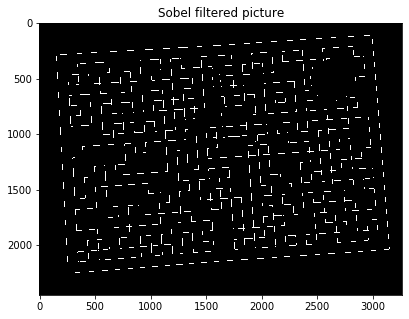

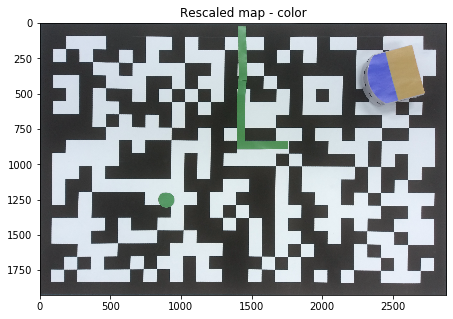

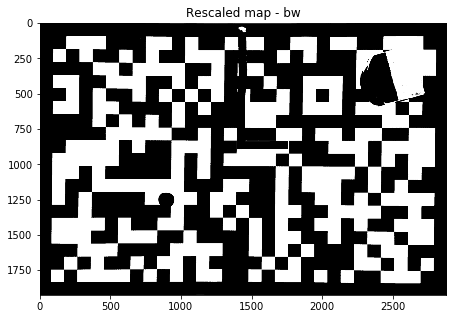

In [24]:
output_sobel, rescaled, rescaled_bw = rectify_map(path)
### Intermediary plots
# source "gray" image
plt.figure()
plt.imshow(output_sobel, cmap="gray") # cmap="gray" <-- to have pure blacks
plt.title('Sobel filtered picture')
# rescaled map (color)
#--------------------
plt.figure()
plt.imshow(rescaled, cmap="gray")
plt.title('Rescaled map - color')
#--------------------
# rescaled_bw map (black and white)
plt.figure()
plt.imshow(rescaled_bw, cmap="gray")
plt.title('Rescaled map - bw')

## Detect Thymio pose

Text(0.5, 1.0, 'mask_Thymio')

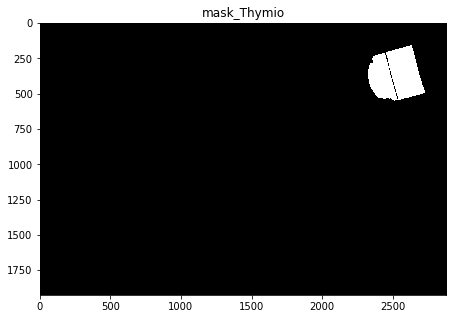

In [25]:
mask_Thymio, start_pxl = detect_thymio_pose(rescaled)
### Intermediary plot
# mask_Thymio
plt.figure()
plt.imshow(mask_Thymio, cmap="gray")
plt.title('mask_Thymio')

## Detect obstacles
The fixed obstacles have been chosen to be green because this colour appeared to be easily distinguished with the colours used to identify the robot (red and turquoise) using a range of HSV (i.e. Hue, Saturation, Value) values. 
The robot “identification suit” is composed of a turquoise rectangle (the rear part of the robot), whose mean (in term of pixels position) renders directly the center of the robot (situated between its two wheels), and a red part (the front part of the robot). This organisation of these two easily distinguishable colours (through a range of HSV values) is finally used to retrieve the orientation of the robot by determining the geometric center of each coloured shape (simply by taking their mean in term of pixels position) and making use of some simple trigonometry.
Since our colour detection is based on HSV values, we have calibrated our algorithm using a specific device (the 8 megapixels camera of a 2013 Apple iPhone 5s of one of the teammates) under specific illuminations conditions that could differ from the ones we could have during the demo.

Text(0.5, 1.0, 'mask_obst')

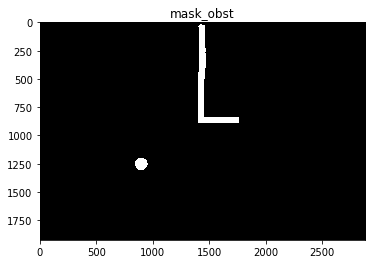

In [8]:
mask_obst = detect_obstacles(rescaled)
### Intermediary plot
# mask_obst
plt.figure()
plt.imshow(mask_obst, cmap="gray")
plt.title('mask_obst')

## Remapping
The coordinates of the fixed obstacles are voluntarily extended in order to make sure that the robot doesn’t run on them while reaching its goal. This is done in the function remapping, at the very end of the vision algorithm.

In [9]:
# Cf. adaptation of "MapNode class" of exercise week 8, "Genetic algorithms"
# Class to handle "MapNode" to represent nodes in the map.
# Each of those nodes is defined by a set of coordinates, the color of the ground at this location
# and a flag that marks it as an obstacle or not.
# The __repr__ function is also defined to print the node in a graphical way.
Map, Pattern, obstacles, start = remapping(rescaled_bw, mask_obst, mask_Thymio, dimX, dimY, start_pxl)
np.set_printoptions(threshold=np.inf)
print(Map)

[[x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x]
 [x                         x x x x x                         x]
 [x                         x x x x x                         x]
 [x                         x x x x x                         x]
 [x                         x x x x x                         x]
 [x                         x x x x x                         x]
 [x                         x x x x x                         x]
 [x                         x x x x x x                       x]
 [x                         x x x x x x x                     x]
 [x                         x x x x x x x x                   x]
 [x                           x x x x x x                     x]
 [x                 x           x x x x                       x]
 [x               x x x                                       x]
 [x             x x x x x                                     x]
 [x               x x x                                       x]
 [x                 x    

# Path planning using A* algorithm
The choice for the A* algorithm comes from the fact that it was well suited to the map provided by the vision as it provides an occupation grid. Vertices of the obstacles could also be retrieved, but the implementation in an algorithm as cell decomposition or a visibility graph is quite complex. On the other hand, a Voronoi algorithm could also be heavy from a computational point of view and the provided path would not be optimal at all.
Last but not least, as the robot is nonholonomic it would require a quite complex algorithm in order to use a potential field approach for the global navigation. Moreover, it doesn’t remove the risk of being trapped somewhere and therefore the potential field was abandoned.

Please note that the Vision part of the code presented above automatically increases the size of the obstacles in order to take into account the size of the robot when passing near an obstacle. 
On the downside, the drawback of the A* algorithm is that the set of visited coordinates leads to plenty of changes in the heading of the robot. This increases the uncertainty on the position. This problem would be minimised by the use of a cell decomposition or a visibility graph algorithm, which would mainly use long straight lines between obstacle’s edges and therefore provide the shortest path available.

#### Input
<ul>
    <li> Obstacles map</li>
    <li> Thymio initial position</li>
    <li> Goal </li>
</ul>

#### Output
<ul>
    <li>Set of coordinates that should be visited by the robot to reach the goal </li>
   <li>Set of points visited by the algorithm </li>
</ul>

## Plot Thymio and environment
#### This code is the one provided on the Moodle page of the course, with some minor modifications.

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d808a59748>)

<Figure size 432x288 with 0 Axes>

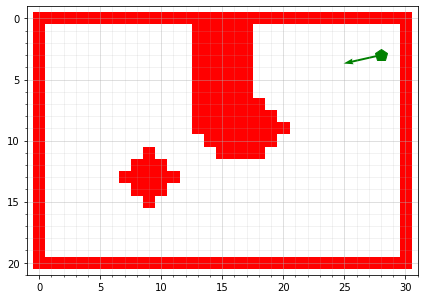

In [10]:
%run py_files\path_planning.py
%run py_files\plot_path_planning.py

# Plot obstacles and Thymio orientation
PlotInitialMap(obstacles, start)

## Define the goal and plot the optimal path

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d808c92400>)

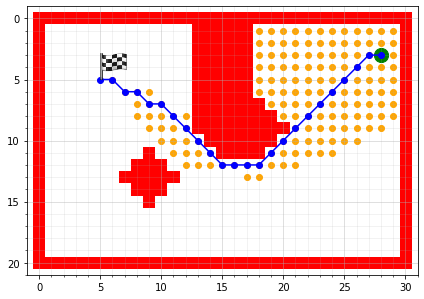

In [13]:
# Set goal
goal = (5,5) # First coordinate: horizontal axis, second coordinate: vertical axis

# Compute optimal path
optimal_path, visitedNodes = RunA_Star(obstacles, (start[0],start[1]), goal)

# Plot optimal path
PlotPathMap(obstacles, (start[0],start[1]), goal, optimal_path, visitedNodes)

## Ground sensors, proximity sensors and odometry mesurements

In [16]:
# %load py_files\measurements.py

def speed_measurement(motor_speed,coeff_forward):
    # Measures motors speed
    speed_left = th["motor.left.speed"]
    speed_right = th["motor.right.speed"]
    
    # Take the mean value
    motor_mean = np.mean([speed_left, speed_right])
    
    # Converts to unit of grid per second
    if motor_mean > motor_speed*1.1:
        speed = motor_speed*coeff_forward
    else:
        speed = motor_mean*coeff_forward    
                     
    return speed

def ground_measurement(ground_sensed):
    
    ground_values = th["prox.ground.delta"]
    
    # Update last measurement
    last_ground_sensed = ground_sensed
    
    # If color sensed is white -> set new measurement to 0
    if ground_values[0] > 500:
        ground_sensed = 0
    else:
        ground_sensed = 1
        
    return last_ground_sensed, ground_sensed        

# Navigation

## Monte Carlo localisation algorithm

By combining odometry measurements and ground vision, an estimate of Thymio position can be computed using MCL algorithm. The use of a ground pattern cannot be easily implemented using Kalman filter as the probability repartition isn't a single Gaussian. A grid based algorithm could have been chosen but is more difficult to implement. The Monte Carlo algorithm is straightforward to implement and combines well with ground patterns.

#### Input
<ul>
    <li> Approximative position or set of states estimate. </li>
    <li> Ground sensors values. </li>
    <li> Thymio speed and orientation. </li>
    <li> Ground pattern. </li>
    <li> Time since last computation. </li>
</ul>

#### Output
<ul>
    <li> New set of states estimate. </li>
</ul>

### State estimate

From the repartition of the particles (density), an estimate of the position is obtained.

#### Input
<ul>
    <li> Set of state particles</li>
</ul>

#### Output
<ul>
    <li> One state estimate </li>
</ul>

#### Reference
https://github.com/epfl-mobots/thymio-ground-localisation/blob/master/code/localize_with_montecarlo.pyx

## Limitations
<ul>
    <li> Kidnapping not allowed, it requires to travel long distance before converging. It would be necessary to have a bigger map and the certitude of never crossing any undetectable obstacle from proximity sensors. </li>
    <li> Heavy computationnal time. To correctly track the robot, it requires a slow speed and a precise model. For this purpose, it is imposed to move the robot only by turning around the center of its wheels axis or going straight forward. </li>
    <li> During the computation of the new position, the robot is still moving but it is unnable to react to any obstacle. 
    <li> For simplicity, only one ground sensor is used. </li>
    <li> This algorithm needs more room to converge at the chosen speed. Here the map is too short and too crowded for the robot size. 
</ul>

## Improvements
<ul>
    <li> Adding more shades of grey for the ground pattern could improve the filtering. </li>
    <li> Take benefit of the second sensor available. </li>
    <li> Implement parallel computing to be more reactive.</li>
</ul>

### Odometry and ground pattern measurement

In [17]:
# %load py_files\position_estimate.py
import math as m
import numpy as np
from random import sample
from numpy import ndarray

def mcl(speed, Ts, ground_truth, last_ground_sensed, ground_sensed, particles, theta, nb_particles):
    """
    Returns the state estimate (position 2D and velocities 2D) using Monte Carlo Localisation algorithm.
    Discrete LTI system: x+ = Ax + Bu
    with x = [posX,posY] and speed = motorspeeds
    
    :param:
                ground_truth, binary mapping of the ground (NxN)
                particles, particles state from previous iteration (Mx3)
                groud_sensed, binary value from the ground sensor (1x1)
                speed (1x1), motor speed
                Ts, time since last iteration (1x1)
                nb_particles, number of particles for the filter (1x1)
    :return: 
                particles, updated particles (Mx3)
    """
    
    nb_rand_particles = 0
    cov = [[0.03*Ts,0],[0,0.3*Ts]]
    tot_particles = nb_particles + nb_rand_particles
    CM_to_sensor = [2.33*m.cos(theta)+0.25*m.sin(theta), 2.33*m.sin(theta)-0.25*m.cos(theta)] # 7 cm for 3 cm grid
    x_max = 30 
    y_max = 20
    
    # Add random particles to the set
    rand_particles = np.random.rand(nb_rand_particles,2)
    rand_particles[:,0] = rand_particles[:,0]*x_max
    rand_particles[:,1] = rand_particles[:,1]*y_max
    particles = np.concatenate((particles,rand_particles),axis=0)
    
    # Converts array to list
    particles = particles.tolist()
    
    # Create an empty temporary set
    particles_tilde = ndarray((tot_particles,2),float)    
    w = np.empty(tot_particles)
    xi = np.empty(2)
    for i in range(tot_particles):
    
        # Sample one particle from the set without replacement
        xi = sample(particles,1)
        xi = xi[0]
        # Update position of particule based on the model
        xi[0] = xi[0] + m.cos(theta)*speed*Ts
        xi[1] = xi[1] + m.sin(theta)*speed*Ts
        
        # Select a particle on a gaussian distribution around updated position
        xi = np.random.multivariate_normal(xi, cov, 1)
        xi = xi[0]
        
        # Compute weight associated to position and add it to state
        # Points outside map are white == 0
        if xi[0]+CM_to_sensor[0] < -0.5 or xi[0]+CM_to_sensor[0] > x_max+0.49 or \
        xi[1]+CM_to_sensor[1] < -0.5 or xi[1]+CM_to_sensor[1] > y_max+0.49 :
            if ground_sensed == 0:
                w[i] = 0.9
            else :
                w[i] = 0.1
                
        else:
            # Get true value of the ground at the updated position
            xi_flat = np.round([xi[0]+CM_to_sensor[0], xi[1]+CM_to_sensor[1]])
            xi_ground_truth = ground_truth[int(xi_flat[0]),int(xi_flat[1])]
            if xi_ground_truth == ground_sensed :
                w[i] = 0.9
            else :
                w[i] = 0.1
        
        # Add updated particule to the temporary set
        particles_tilde[i] = xi
        
    # Recover weigths
    w = w/sum(w)
    # Sample randomly from the temporary set according to the weigths
    particles = particles_tilde[np.random.choice(particles_tilde.shape[0], nb_particles, replace=True, p=w),0:2]

    return(particles)
    
def estimate_state(particles):    
    # limits for considering participating to the state estimation
    xy_lim = 1.5

    # RANSAC to find best index
    iterations_count = 500
    tests_count = 500
    index = -1
    o_index = -1
    best_index = -1
    support = 0
    best_support = 0
    particles_view = np.asarray(particles)
    max_index = particles_view.shape[0]-1
    iteration_indices = np.random.randint(0, max_index, [iterations_count])
    test_indices = np.random.randint(0, max_index, [tests_count])

    # tries a certain number of times
    for i in range(iterations_count):
        index = iteration_indices[i]
        x = particles_view[index, 0]
        y = particles_view[index, 1]
        support = 0
        for j in range(tests_count):
            o_index = test_indices[j]
            o_x = particles_view[o_index, 0]
            o_y = particles_view[o_index, 1]
            # compute distance
            dist_xy = m.sqrt((x-o_x)*(x-o_x) + (y-o_y)*(y-o_y))
            if dist_xy < xy_lim:
                support += 1
        # if it beats best, replace best
        if support > best_support:
            best_index = index
            best_support = support
    # then do the averaging for best index
    x = particles_view[best_index, 0]
    y = particles_view[best_index, 1]
    xs = 0.
    ys = 0.
    count = 0
    #conf_count = 0
    for j in range(tests_count):
        o_index = test_indices[j]
        o_x = particles_view[o_index, 0]
        o_y = particles_view[o_index, 1]
        dist_xy = m.sqrt((x-o_x)*(x-o_x) + (y-o_y)*(y-o_y))
        if dist_xy < xy_lim:
            xs += o_x
            ys += o_y
            count += 1
    assert count > 0, count
    x_m = xs / count
    y_m = ys / count
    return np.array([x_m, y_m])

def print_particles(particles):
    plt.cla()
    plt.clf()
    plt.close()
    # create data
    x = particles[:,0]
    y = particles[:,1]

    # Big bins
    h,_, _, _ = plt.hist2d(x, y, range=[[0, 30], [0, 20]], bins=(30, 20), cmap=plt.cm.BuPu)

    # Limits
    plt.axvline(0, color='black')
    plt.axhline(0, color='black')
    plt.axvline(30, color='black')
    plt.axhline(20, color='black')

    # State
    plt.axvline(state[0], color='r')
    plt.axhline(state[1], color='green')

    plt.colorbar()
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.gca().invert_yaxis()
    plt.show()

## Local navigation using proximity sensors 

The robot needs to avoid the obstacles unseen by the vision. To do so, the horizontal proximity sensors of the robot are used to detect if there is anything in front of him. The objective is then to move aside from the obstacle and replan an optimal path to the goal.

#### Input
<ul>
    <li> Values of proximity sensors. </li>
</ul>

#### Output
<ul>
    <li> Motors control. </li>
    <li> New otpimal path to the goal. </li>
    <li> Actual estimated position of the robot. </li>
</ul>

#### Limitations
<ul>
    <li> The robot cannot move through an arc of circle but can only move straight forward or turn around the center of its wheels axis. As a result the wall of the obstacle cannot be followed smoothly to find again the optimal path. The only solution to avoid the obstacle is to orient the robot away from it and go forward for a fixed amount of time. This is a really limited approach but enoughly simple in order to not lose track of the robot position. </li>
    <li> The fix amount of time is difficult to set without prior knowledge of the obstacles size. If it's too short then the robot will take a lot of time to completely avoid the obstacle as it will neeed to repeat multiple cycle of moving aside + computation of new optimal path. On the opposite, if it's too long then the robot can run over fixed obstacles seen by the vision but not from the proximity sensors. </li>
</ul>

In [18]:
# %load py_files\local_navigation.py
def local_nav(sens,treshold_side,treshold_obst,time_forward,motor_speed,motor_rot,particles,ground_truth,ground_sensed,theta,nb_particles):
    
    # follow the obstacle by the left
    if (sens[0]+sens[1]) > (sens[4]+sens[3]) :
        state, theta, particles = side_by_left(sens,treshold_side,time_forward,motor_speed,motor_rot,particles,ground_truth,ground_sensed,theta,nb_particles)
    # follow the obstacle by the right    
    else :
        state, theta, particles = side_by_right(sens,treshold_side,time_forward,motor_speed,motor_rot,particles,ground_truth,ground_sensed,theta,nb_particles)
    
    return state, theta, particles
        
def side_by_left(sens,treshold_side,time_forward,motor_speed,motor_rot,particles,ground_truth,ground_sensed,theta,nb_particles) :
    c = 0  #to start the timer only the first time one enter into the loop
    
    # turn right until the sensor don't see anything
    while sum(sens[i] > treshold_side for i in range(0,len(sens)-2)) > 0 :
        
        motor_rotate("right",motor_rot)
        
        # Set turn-right timer
        if c == 0 :
            t_start = time.perf_counter()
            c=1
    
        sens = th["prox.horizontal"]
        if sum(sens[i] > treshold_side for i in range(0,len(sens)-2)) == 0:
            # Stop turn-right timer
            t_stop = time.perf_counter()
            T_l = t_stop - t_start
            
            # Computes new angle
            dtheta = rot_angle(T_l,coeff_rot)
            theta = theta+dtheta
            
            # Goes forward
            Ts, speed = local_forward(motor_speed,time_forward,treshold_side)
            
            # Measures ground and computes new state
            last_ground_sensed, ground_sensed = ground_measurement(ground_sensed)
            particles = mcl(speed, Ts, ground_truth, last_ground_sensed, ground_sensed, \
                        particles, theta, nb_particles)
            state = estimate_state(particles)

    return state, theta, particles

def side_by_right(sens,treshold_side,time_forward,motor_speed,motor_rot,particles,ground_truth,ground_sensed,theta,nb_particles) :
    c=0  #to start the timer only the first time one enter into the loop
    
    # turn left until the sensor don't see anything
    while sum(sens[i] > treshold_side for i in range(0,len(sens)-2)) > 0 :
        
        motor_rotate("left",motor_rot)
        
        # Set turn-left timer
        if c == 0 :
            t_start = time.perf_counter()
            c=1
    
        sens = th["prox.horizontal"]
        if sum(sens[i] > treshold_side for i in range(0,len(sens)-2)) == 0:
            # Stop turn-left timer
            t_stop = time.perf_counter()
            T_r = t_stop - t_start
            
            dtheta = rot_angle(T_r,coeff_rot)
            theta = theta-dtheta
            
            # Going straight if any other obstacle is encountered
            Ts, speed = local_forward(motor_speed,time_forward,treshold_side)
            last_ground_sensed, ground_sensed = ground_measurement(ground_sensed)
            particles = mcl(speed, Ts, ground_truth, last_ground_sensed, ground_sensed, \
                        particles, theta, nb_particles)
            state = estimate_state(particles)

    return state, theta, particles

def local_forward(motor_speed,time_forward,treshold_close): 
    # Set motors speed to go forward
    speed = 0
    motor_forward(motor_speed)
    
    # Increment time counter while checking for obstacles
    step_forward = time_forward/50
    nb_step = 0
    for i in range (50):
        sens=th["prox.horizontal"]
        if sum(sens[i] > treshold_close for i in range(0,len(sens)-2)):
            break    
        time.sleep(time_forward/50)
        speed = speed + speed_measurement(motor_speed,coeff_forward)
        nb_step = nb_step + 1
    # Stop motors
    motor_stop()
    
    # Compute time forward and average speed
    Ts = nb_step*step_forward
    if nb_step != 0:
        speed = speed/nb_step

    return Ts, speed

## Motor control 

From the actual estimate of position and the set of points from the optimal path, the controller drives the robot along it until reaching the goal. In order to avoid the robot to recorrect its orientation too often, the reference point tracked is taken a few points ahead of the actual closest point of the optimal path. The drawback of this approach is that the robot could cross an obstacle instead of stricly respecting a planned corner.

In [19]:
# %load py_files\motor_control.py
import math as m
import time

def motor_stop():
    th.set_var("motor.left.target", 0)
    th.set_var("motor.right.target", 0) 
    
def motor_forward(motor_speed):
    th.set_var("motor.left.target", motor_speed)
    th.set_var("motor.right.target", motor_speed)
    
def motor_rotate(direction,motor_rot):

    if direction == "left":
        th.set_var("motor.right.target",motor_rot)
        th.set_var("motor.left.target",2**16 - motor_rot)
        
    if direction == "right":
        th.set_var("motor.left.target",motor_rot)
        th.set_var("motor.right.target",2**16 - motor_rot)  
        
def global_controller(state,theta,reference,motor_speed,motor_rot,coeff_rot):
    dist_vector = reference-state # vector between state and reference
    theta_ref = m.atan2(dist_vector[1],dist_vector[0]) # Vector angle from x-axis 
    dtheta = normalise_angle(theta_ref - theta) # Normalize angle to minimise rotation (270deg -> -90°)
        
    if abs(dtheta) > m.pi/16:
        theta = theta + dtheta
        
        if dtheta < 0: # Opposite from convention
            motor_rotate("left",motor_rot)
        else:
            motor_rotate("right",motor_rot)
            
        time.sleep(abs(coeff_rot*dtheta/(2*m.pi)))# 8.246 [s] for 2pi rad turn
        
        motor_stop()  
    
    motor_forward(motor_speed)
    
    return theta

def rot_angle(Ts,coeff_rot):
    dtheta = Ts*2*m.pi/coeff_rot
    return dtheta


# %load py_files\navigation.py
import math as m
import numpy as np

def target(pos,optimal_path,k):
    """
   Set new reference to follow
    
    :param:
                pos, position (2x1) (first 2 rows of state estimate)
                global_path, optimal path from A* alg (2xn)
    :return: 
                target, reference position to go to(2x1)
    """          
    #k = 2 # constant for uplooking in the optimal 
                
    # Compute distance between Thymio and each position of the optimal path
    dist = np.linalg.norm(pos-optimal_path, axis=1)      
    # Selects the closest point
    step = np.argmin(dist)
    if step + k < len(optimal_path):
        reference = optimal_path[step+k]
    else:
        reference = optimal_path[-1]
    return reference

def goal_reached():
    motor_stop()
    
def normalise_angle(alpha):
    while alpha > m.pi:
        alpha -= 2. * m.pi
    while alpha < -m.pi:
        alpha += 2. * m.pi
    return alpha

## Initialisation of the tracking

In [20]:
# Distance limits
eps_close = 2
eps_goal = 1
eps_far = 3

k = 2 # Nb of steps forward for reference
Ts = 0 # Init timer
last_case = 0 # Init case (global:0 or local:1)

# MCL
nb_particles = 2000 # Nb of particles 
cov = [[0.1, 0], [0, 0.1]] # Covariance from vision

# Local navigation tresholds
treshold_side = 100  # treshold setting the distance to the wall before going away of it
treshold_obst = 2250 # treshold for entering in local navigation
time_forward = 6 # time going away from obstacle before new computation

# Motor speeds
motor_speed = 50 # Forward
coeff_forward = 0.0124 # Conversion factor from forward speed to time (the higher, more he thinks it advanced)
motor_rot = 50 # Rotation 
coeff_rot = 16.5 # Conversion factor from rotation speed to time (the higher, more it rotates)

# Initial ground_sensed
ground_sensed = 2 # initialise the ground sensing variable to unknown (=2)

# Get map information
Map, ground_truth, obstacles, start = vision(path,dimX,dimY)
ground_truth = ground_truth.transpose()

# Get starting state and angle
state = np.asarray(start[0:2]) # [6,9]
theta = start[2]*m.pi/180 

# Initialise particles for MCL
particles = np.random.multivariate_normal(state, cov, nb_particles)

## Tracking

#### Input
<ul>
    <li> Initial position, orientation and ground pattern </li>
    <li> Optimal path </li>
    <li> Ground and proximity sensors values </li>
</ul>

#### Output
<ul>
    <li> Motor speed values </li>
</ul>

### Implementation


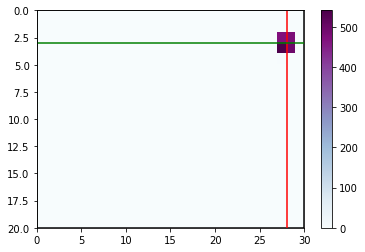

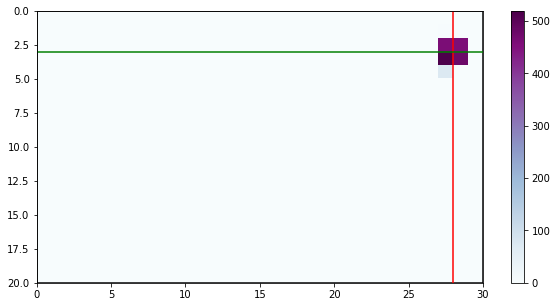

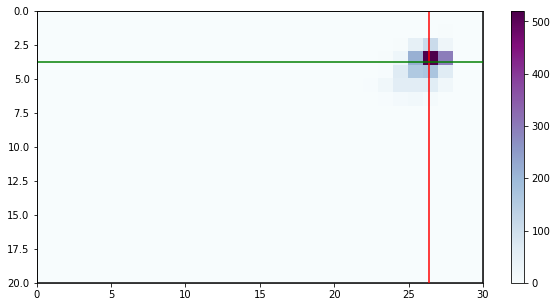

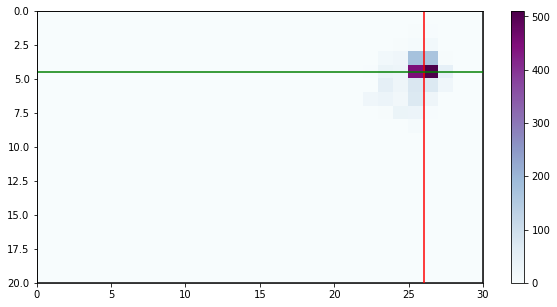

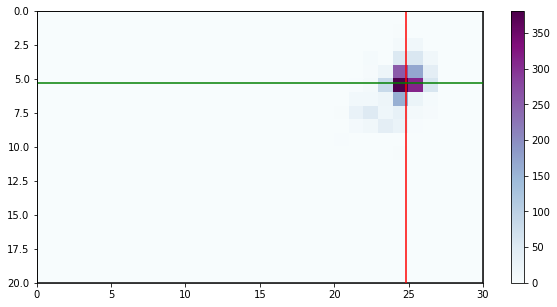

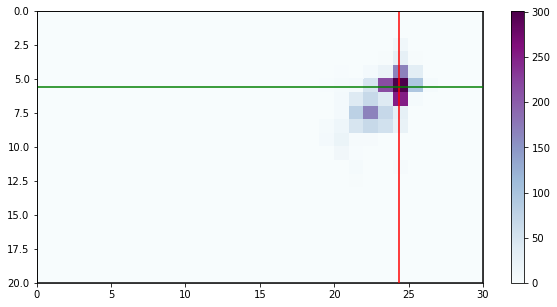

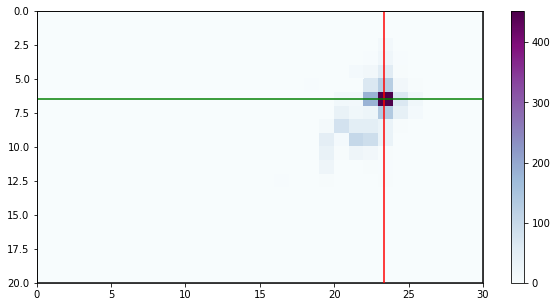

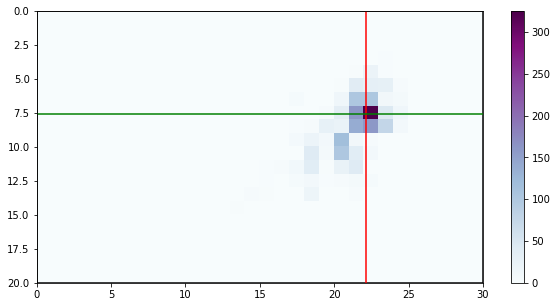

Entering local navigation.
New optimal path computed, back in global navigation.


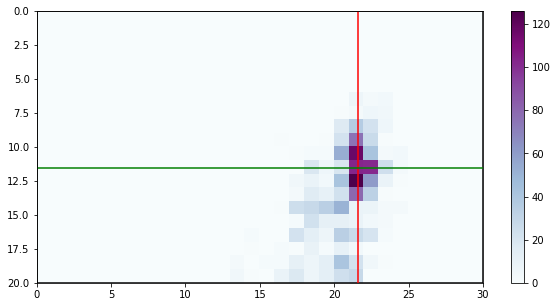

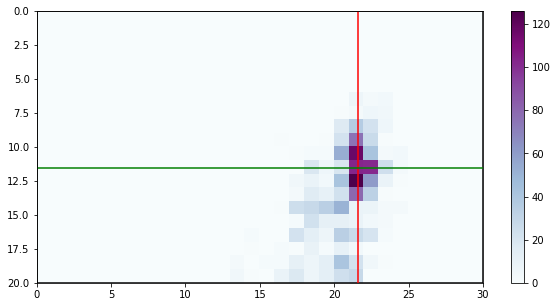

Entering local navigation.
New optimal path computed, back in global navigation.


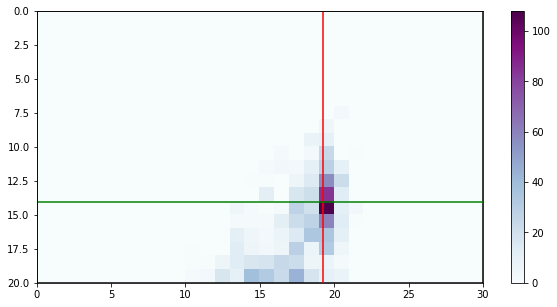

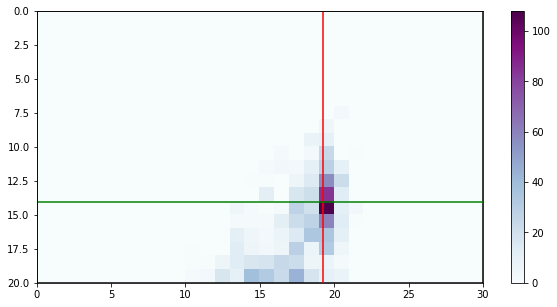

Entering local navigation.
New optimal path computed, back in global navigation.


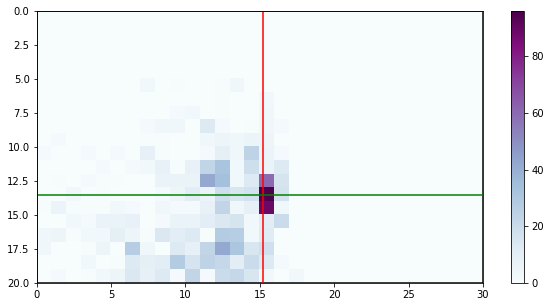

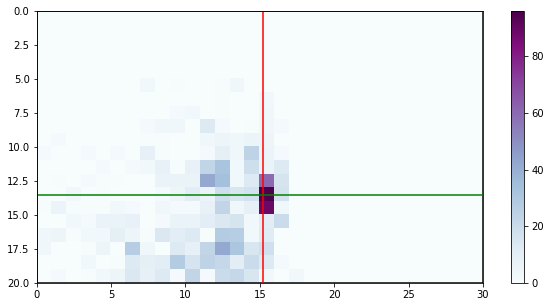

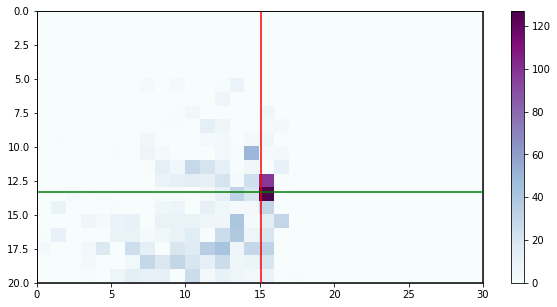

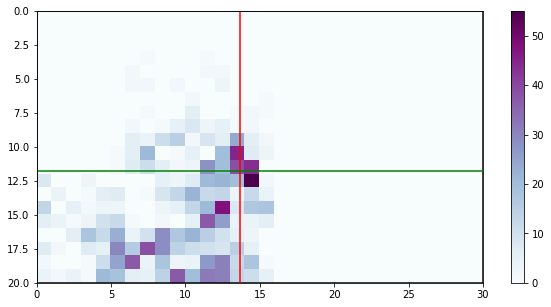

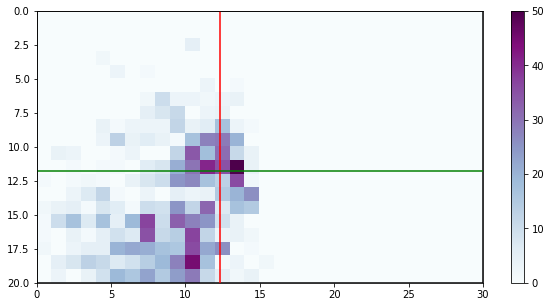

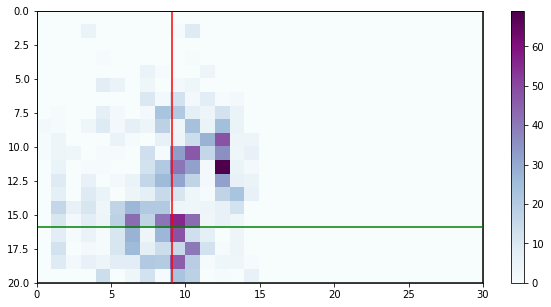

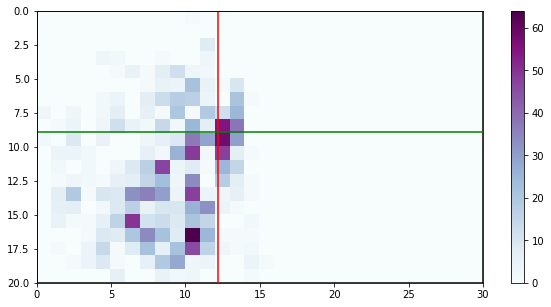

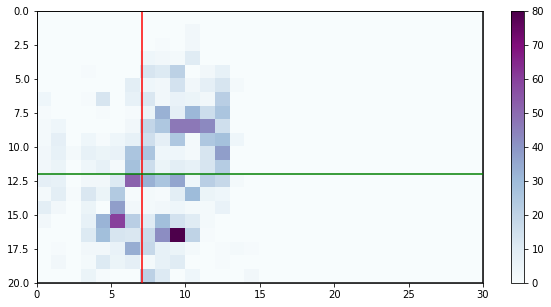

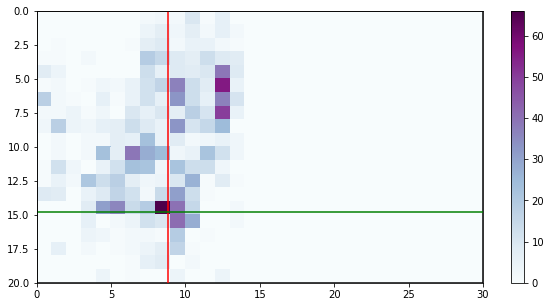

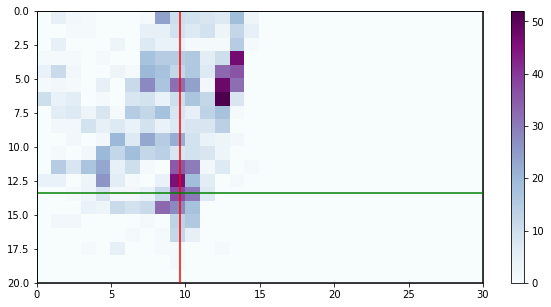

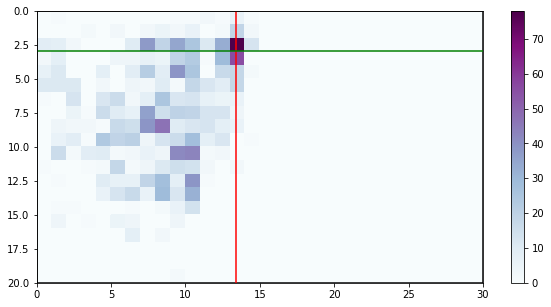

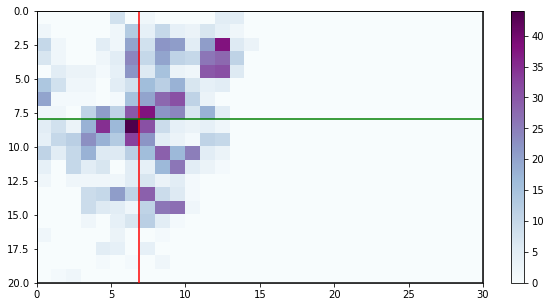

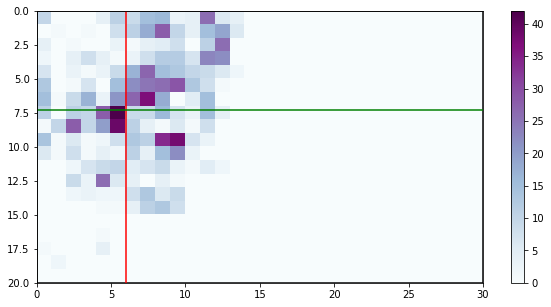

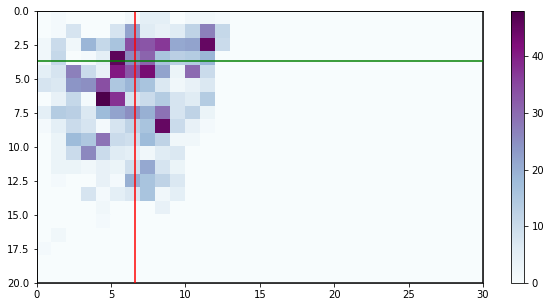

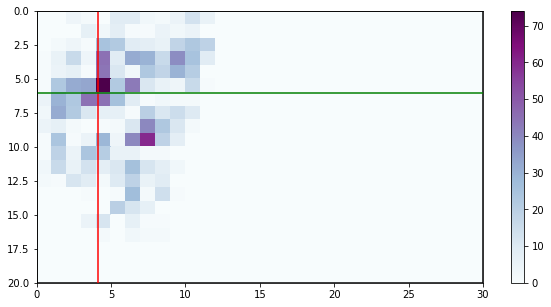

In [21]:
# Get first reference position
reference = optimal_path[k]

# Adjust angle and goes forward
theta = global_controller(state,theta,reference,motor_speed,motor_rot,coeff_rot)

# Starts timer
t_start = time.perf_counter()

# Keep going while goal not reached
while np.linalg.norm(state-goal) > eps_goal:
    print_particles(particles)
    
    # Do measurements
    last_ground_sensed, ground_sensed = ground_measurement(ground_sensed)
    speed = speed_measurement(motor_speed,coeff_forward)  
    sens = th["prox.horizontal"]
    
    # Checking if should be in local or global navigation
    if sum([sens[i] > treshold_obst for i in range(0,len(sens)-2)]) < 1 :  
        case = 0  # global navigation
                
    else : 
        case = 1  #local avoidance
        print("Entering local navigation.")
    
    # Global navigation
    if case == 0 :
        # Compute new state if previously in global
        if last_case == 0:
            particles = mcl(speed, Ts, ground_truth, last_ground_sensed, ground_sensed, particles, theta, 
                            nb_particles)
            state = estimate_state(particles)  
        
        # Get new reference
        reference = target(state,optimal_path,k)

        # Records time forward to later compute new state
        t_stop = time.perf_counter()
        if last_case == 0:
            Ts = t_stop-t_start
        else:
            Ts = 0

        # Corrects angle and goes forward
        theta = global_controller(state,theta,reference,motor_speed,motor_rot,coeff_rot) 

        # Restarts timer
        t_start = time.perf_counter()
        
        last_case = 0
        
    # Local navigation
    elif case == 1 :
        # Stops
        motor_stop()
        
        # If previously in global navigation, computes actual position
        if last_case == 0:
            # Records time forward in global before entering in local
            t_stop = time.perf_counter()
            Ts = t_stop-t_start
            # Compute new position
            particles = mcl(speed, Ts, ground_truth, last_ground_sensed, ground_sensed, particles, theta, 
                            nb_particles)
            state = estimate_state(particles) 
        
        # Enters local naviagtion
        state, theta, particles = local_nav(sens,treshold_obst,treshold_side,time_forward,motor_speed,motor_rot,
                                            particles,ground_truth,ground_sensed,theta,nb_particles)
        
        # Recovers new starting position for optimal path
        new_start = (int(round(state[0])), int(round(state[1])))
        optimal_path, visitedNodes = RunA_Star(obstacles, new_start, goal)
        PlotPathMap(obstacles, new_start, goal, optimal_path, visitedNodes) 
        print("New optimal path computed, back in global navigation.")
        
        # Gets new reference
        reference = optimal_path[k]
        last_case = 1

# Reached goal
goal_reached()

#### Quick stop

In [ ]:
motor_stop()
print_particles(particles)